# Drowsiness Detection Model Training
This notebook trains a model to detect if a person is awake or sleeping in vehicles.
The model can detect multiple people and predict their age when sleeping.

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import requests
import zipfile

## Download MRL Eye Dataset
We'll use the MRL Eye Dataset which has 84,898 samples of open and closed eyes.

In [2]:
# Download dataset (you need to manually download from Kaggle)
# Dataset: https://www.kaggle.com/datasets/prasadvpatil/mrl-dataset

# For this example, we'll create a sample dataset structure
dataset_path = '../datasets/drowsiness_data'
os.makedirs(f'{dataset_path}/train/open_eyes', exist_ok=True)
os.makedirs(f'{dataset_path}/train/closed_eyes', exist_ok=True)
os.makedirs(f'{dataset_path}/val/open_eyes', exist_ok=True)
os.makedirs(f'{dataset_path}/val/closed_eyes', exist_ok=True)

print('Dataset directory structure created.')
print('Please download the MRL dataset from Kaggle and place images in the respective folders.')

Dataset directory structure created.
Please download the MRL dataset from Kaggle and place images in the respective folders.


## Data Preprocessing

In [ ]:
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 32
EPOCHS = 25

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    f'{dataset_path}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = val_datagen.flow_from_directory(
    f'{dataset_path}/train',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


## Model Architecture
Using VGG16 with transfer learning for eye state classification

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

eye_state = Dense(2, activation='softmax', name='eye_state')(x)

age_pred = Dense(1, activation='linear', name='age_pred')(x)

model = Model(inputs=base_model.input, outputs=[eye_state, age_pred])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'eye_state': 'categorical_crossentropy',
        'age_pred': 'mse'
    },
    metrics={
        'eye_state': ['accuracy'],
        'age_pred': ['mae']
    }
)

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 224s 4us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Training

In [6]:
model = Model(inputs=base_model.input, outputs=eye_state)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
    tf.keras.callbacks.ModelCheckpoint('drowsiness_model.h5', save_best_only=True)
]



history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6131 - loss: 0.6582

100/100 ━━━━━━━━━━━━━━━━━━━━ 557s 6s/step - accuracy: 0.6712 - loss: 0.5945 - val_accuracy: 0.5550 - val_loss: 0.6281 - learning_rate: 0.0010
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7637 - loss: 0.4920

100/100 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - accuracy: 0.7887 - loss: 0.4610 - val_accuracy: 0.8087 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8310 - loss: 0.3930

100/100 ━━━━━━━━━━━━━━━━━━━━ 540s 5s/step - accuracy: 0.8447 - loss: 0.3736 - val_accuracy: 0.7975 - val_loss: 0.4637 - learning_rate: 0.0010
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8653 - loss: 0.3272

100/100 ━━━━━━━━━━━━━━━━━━━━ 536s 5s/step - accuracy: 0.8731 - loss: 0.3184 - val_accuracy: 0.8562 - val_loss: 0.4132 - learning_rate: 0.0010
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8924 - loss: 0.2801

100/100 ━━━━━━━━━━━━━━━━━━━━ 529s 5s/step - accuracy: 0.9041 - loss: 0.2726 - val_accuracy: 0.8500 - val_loss: 0.3855 - learning_rate: 0.0010
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9016 - loss: 0.2625

100/100 ━━━━━━━━━━━━━━━━━━━━ 527s 5s/step - accuracy: 0.9081 - loss: 0.2483 - val_accuracy: 0.8825 - val_loss: 0.3755 - learning_rate: 0.0010
Epoch 7/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9188 - loss: 0.2313

100/100 ━━━━━━━━━━━━━━━━━━━━ 540s 5s/step - accuracy: 0.9234 - loss: 0.2267 - val_accuracy: 0.8838 - val_loss: 0.3532 - learning_rate: 0.0010
Epoch 8/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9295 - loss: 0.2149

100/100 ━━━━━━━━━━━━━━━━━━━━ 550s 6s/step - accuracy: 0.9256 - loss: 0.2121 - val_accuracy: 0.8888 - val_loss: 0.3419 - learning_rate: 0.0010
Epoch 9/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9279 - loss: 0.2079

100/100 ━━━━━━━━━━━━━━━━━━━━ 608s 6s/step - accuracy: 0.9209 - loss: 0.2086 - val_accuracy: 0.8612 - val_loss: 0.3383 - learning_rate: 0.0010
Epoch 10/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9297 - loss: 0.2008

100/100 ━━━━━━━━━━━━━━━━━━━━ 538s 5s/step - accuracy: 0.9372 - loss: 0.1858 - val_accuracy: 0.8712 - val_loss: 0.3134 - learning_rate: 0.0010
Epoch 11/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 573s 6s/step - accuracy: 0.9384 - loss: 0.1810 - val_accuracy: 0.9275 - val_loss: 0.3602 - learning_rate: 0.0010
Epoch 12/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 573s 6s/step - accuracy: 0.9413 - loss: 0.1714 - val_accuracy: 0.8612 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 13/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 533s 5s/step - accuracy: 0.9444 - loss: 0.1603 - val_accuracy: 0.8925 - val_loss: 0.3842 - learning_rate: 0.0010
Epoch 14/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9441 - loss: 0.1553

100/100 ━━━━━━━━━━━━━━━━━━━━ 652s 7s/step - accuracy: 0.9506 - loss: 0.1429 - val_accuracy: 0.9000 - val_loss: 0.3001 - learning_rate: 5.0000e-04
Epoch 15/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 667s 7s/step - accuracy: 0.9534 - loss: 0.1381 - val_accuracy: 0.8675 - val_loss: 0.3032 - learning_rate: 5.0000e-04
Epoch 16/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9461 - loss: 0.1473

100/100 ━━━━━━━━━━━━━━━━━━━━ 566s 6s/step - accuracy: 0.9513 - loss: 0.1394 - val_accuracy: 0.8950 - val_loss: 0.2900 - learning_rate: 5.0000e-04
Epoch 17/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 536s 5s/step - accuracy: 0.9566 - loss: 0.1260 - val_accuracy: 0.8687 - val_loss: 0.2961 - learning_rate: 5.0000e-04
Epoch 18/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9512 - loss: 0.1323

100/100 ━━━━━━━━━━━━━━━━━━━━ 673s 7s/step - accuracy: 0.9559 - loss: 0.1242 - val_accuracy: 0.9075 - val_loss: 0.2869 - learning_rate: 5.0000e-04
Epoch 19/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 655s 7s/step - accuracy: 0.9613 - loss: 0.1215 - val_accuracy: 0.9237 - val_loss: 0.3032 - learning_rate: 5.0000e-04
Epoch 20/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9477 - loss: 0.1359

100/100 ━━━━━━━━━━━━━━━━━━━━ 621s 6s/step - accuracy: 0.9550 - loss: 0.1250 - val_accuracy: 0.9125 - val_loss: 0.2808 - learning_rate: 5.0000e-04
Epoch 21/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 582s 6s/step - accuracy: 0.9584 - loss: 0.1199 - val_accuracy: 0.8875 - val_loss: 0.2821 - learning_rate: 5.0000e-04
Epoch 22/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 671s 7s/step - accuracy: 0.9603 - loss: 0.1102 - val_accuracy: 0.9300 - val_loss: 0.2898 - learning_rate: 5.0000e-04
Epoch 23/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 640s 6s/step - accuracy: 0.9591 - loss: 0.1153 - val_accuracy: 0.9225 - val_loss: 0.2862 - learning_rate: 5.0000e-04
Epoch 24/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 576s 6s/step - accuracy: 0.9631 - loss: 0.1028 - val_accuracy: 0.9262 - val_loss: 0.3245 - learning_rate: 2.5000e-04
Epoch 25/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 641s 6s/step - accuracy: 0.9647 - loss: 0.1006 - val_accuracy: 0.9150 - val_loss: 0.3305 - learning_rate: 2.5000e-04


## Face Detection Integration

In [8]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

def detect_drowsiness(frame, model):
  
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    results = []
    
    for (x, y, w, h) in faces:
        face_roi = gray[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(face_roi)
        
        if len(eyes) >= 2: 
            eye_states = []
            for (ex, ey, ew, eh) in eyes[:2]:  
                eye_img = face_roi[ey:ey+eh, ex:ex+ew]
                eye_img = cv2.resize(eye_img, (IMG_WIDTH, IMG_HEIGHT))
                eye_img = np.expand_dims(eye_img, axis=-1)
                eye_img = np.repeat(eye_img, 3, axis=-1)
                eye_img = np.expand_dims(eye_img, axis=0) / 255.0
                
                eye_pred, age_pred = model.predict(eye_img)
                eye_states.append(np.argmax(eye_pred))
            
            is_sleeping = sum(eye_states) 
            predicted_age = int(age_pred[0][0]) if is_sleeping else None
            
            results.append({
                'bbox': (x, y, w, h),
                'is_sleeping': is_sleeping,
                'age': predicted_age
            })
    
    return results

print('Drowsiness detection function created.')

Drowsiness detection function created.


## Save Model

In [9]:
model.save('drowsiness_detection_model.h5')
print('Model saved successfully!')

Model saved successfully!


In [1]:
import cv2
import dlib
import os

face_detector = dlib.get_frontal_face_detector()

video_path = "input_video.mp4"
output_dir_awake = "dataset/awake"
output_dir_asleep = "dataset/asleep"
os.makedirs(output_dir_awake, exist_ok=True)
os.makedirs(output_dir_asleep, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_num = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detector(gray)
    for i, face in enumerate(faces):
        x, y, w, h = face.left(), face.top(), face.width(), face.height()
        face_crop = frame[y:y + h, x:x + w]
        # Save frame - You must manually label which images are 'awake' or 'asleep'
        # For demo, saving all to awake folder:
        cv2.imwrite(f"{output_dir_awake}/frame_{frame_num}_{i}.jpg", face_crop)
    frame_num += 1
cap.release()


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import tensorflow as tf

class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, directory, age_csv, batch_size, img_size, shuffle=True):
        self.directory = directory
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.df = pd.read_csv(age_csv)
        self.age_map = dict(zip(self.df['filename'], self.df['age']))

        self.classes = sorted(os.listdir(directory))
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

        self.filenames = []
        self.labels = []
        for cls in self.classes:
            cls_dir = os.path.join(directory, cls)
            for fname in os.listdir(cls_dir):
                self.filenames.append(fname)
                self.labels.append(self.class_indices[cls])

        self.indexes = np.arange(len(self.filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images, eye_states, ages = [], [], []

        for i in batch_idx:
            fname = self.filenames[i]
            cls = self.classes[self.labels[i]]
            img_path = os.path.join(self.directory, cls, fname)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            images.append(img)

            label_vec = np.zeros(len(self.classes))
            label_vec[self.labels[i]] = 1
            eye_states.append(label_vec)

            ages.append(float(self.age_map.get(fname, 0)))

        return np.array(images), {'eye_state': np.array(eye_states), 'age_pred': np.array(ages)}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

IMG_HEIGHT, IMG_WIDTH = 224, 224

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

eye_state_output = Dense(2, activation='softmax', name='eye_state')(x)
age_output = Dense(1, activation='linear', name='age_pred')(x)

model = Model(inputs=base_model.input, outputs=[eye_state_output, age_output])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'eye_state': 'categorical_crossentropy',
        'age_pred': 'mean_squared_error'
    },
    metrics={
        'eye_state': ['accuracy'],
        'age_pred': ['mean_absolute_error']
    }
)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,780,739 (56.38 MB)

 Trainable params: 66,051 (258.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [4]:
import os
import csv

# Directory containing MRL images organized in subfolders (e.g., awake, asleep)
dataset_dir = "path_to_mrl_dataset"

# Output CSV path
output_csv = "mrl_dataset_age_labels.csv"

default_age = 25  # Default age to assign

with open(output_csv, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filename', 'age'])  # CSV header

    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                relative_path = os.path.relpath(os.path.join(root, file), dataset_dir)
                # Write filename and default age
                writer.writerow([relative_path, default_age])

print(f"CSV file with default ages saved to {output_csv}")


CSV file with default ages saved to mrl_dataset_age_labels.csv


In [6]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2

class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_dir, age_csv, batch_size, img_size, shuffle=True):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.df = pd.read_csv(age_csv)
        self.age_map = dict(zip(self.df['filename'], self.df['age']))
        self.classes = ['awake', 'asleep']
        self.class_indices = {'awake': 0, 'asleep': 1}

        self.filenames = self.df['filename'].tolist()
        self.indexes = np.arange(len(self.filenames))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        eye_states = []
        ages = []

        for i in batch_idx:
            filename = self.filenames[i]
            filepath = os.path.join(self.root_dir, filename)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            images.append(img)

            # Eye state one-hot
            class_name = filename.split(os.sep)[0]
            eye_label = np.zeros(len(self.classes))
            eye_label[self.class_indices[class_name]] = 1
            eye_states.append(eye_label)

            # Age label
            ages.append(float(self.age_map[filename]))

        return np.array(images), {'eye_state': np.array(eye_states), 'age_pred': np.array(ages)}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [7]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2

class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_dir, age_csv, batch_size, img_size, shuffle=True):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.df = pd.read_csv(age_csv)
        self.age_map = dict(zip(self.df['filename'], self.df['age']))
        self.classes = ['awake', 'asleep']
        self.class_indices = {'awake': 0, 'asleep': 1}

        self.filenames = self.df['filename'].tolist()
        self.indexes = np.arange(len(self.filenames))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images = []
        eye_states = []
        ages = []

        for i in batch_idx:
            filename = self.filenames[i]
            filepath = os.path.join(self.root_dir, filename)
            img = cv2.imread(filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            images.append(img)

            # Eye state one-hot
            class_name = filename.split(os.sep)[0]
            eye_label = np.zeros(len(self.classes))
            eye_label[self.class_indices[class_name]] = 1
            eye_states.append(eye_label)

            # Age label
            ages.append(float(self.age_map[filename]))

        return np.array(images), {'eye_state': np.array(eye_states), 'age_pred': np.array(ages)}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [8]:


train_generator = MultiOutputDataGenerator(
    root_dir='dataset/train',
    age_csv='train_ages.csv',
    batch_size=32,
    img_size=(224, 224)
)

val_generator = MultiOutputDataGenerator(
    root_dir='dataset/val',
    age_csv='val_ages.csv',
    batch_size=32,
    img_size=(224, 224),
    shuffle=False
)

history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)


FileNotFoundError: [Errno 2] No such file or directory: 'train_ages.csv'

In [10]:
import tensorflow as tf
import pandas as pd
import os
import numpy as np
import cv2

class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_dir, age_csv, batch_size, img_size, shuffle=True):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle

        self.df = pd.read_csv(age_csv)
        self.age_map = dict(zip(self.df['filename'], self.df['age']))

        # Update these classes to your actual folder names
        self.classes = ['open_eyes', 'closed_eyes']
        self.class_indices = {cls: idx for idx, cls in enumerate(self.classes)}

        self.filenames = self.df['filename'].tolist()
        self.indexes = np.arange(len(self.filenames))

        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_idx = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images, eye_states, ages = [], [], []

        for i in batch_idx:
            filename = self.filenames[i]
            filepath = os.path.join(self.root_dir, filename)
            img = cv2.imread(filepath)
            if img is None:
                continue  # skip missing or unreadable images
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            img = img / 255.0
            images.append(img)

            # Get class label from folder name at the start of relative path
            class_name = filename.split(os.sep)[0]  
            eye_label = np.zeros(len(self.classes))
            eye_label[self.class_indices[class_name]] = 1
            eye_states.append(eye_label)

            ages.append(float(self.age_map[filename]))

        return np.array(images), {'eye_state': np.array(eye_states), 'age_pred': np.array(ages)}

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


CSV with assigned ages saved to train_age_labels.csv
Total images processed: 4000
CSV with assigned ages saved to val_age_labels.csv
Total images processed: 528


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 14,879,299 (56.76 MB)

 Trainable params: 7,244,035 (27.63 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

None
Found 4000 valid images in C:\Users\sarva\Emotion_detection-main\datasets\drowsiness_data\train
Class distribution: {'open_eyes': 2000, 'closed_eyes': 2000}
Found 528 valid images in C:\Users\sarva\Emotion_detection-main\datasets\drowsiness_data\val
Class distribution: {'open_eyes': 264, 'closed_eyes': 264}
Starting model training with improved configuration...
Phase 1: Training with mostly frozen base model...
Epoch 1/50


e:\kinshu\envs\cv_project\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1113 - age_pred_mae: 0.2821 - eye_state_accuracy: 0.6279 - eye_state_loss: 0.6084 - loss: 0.6195
Epoch 1: val_eye_state_accuracy improved from None to 0.96780, saving model to drowsiness_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 689s 1s/step - age_pred_loss: 0.1159 - age_pred_mae: 0.2855 - eye_state_accuracy: 0.6902 - eye_state_loss: 0.5083 - loss: 0.5199 - val_age_pred_loss: 0.0847 - val_age_pred_mae: 0.2521 - val_eye_state_accuracy: 0.9678 - val_eye_state_loss: 0.1015 - val_loss: 0.1100 - learning_rate: 1.0000e-04
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1173 - age_pred_mae: 0.2844 - eye_state_accuracy: 0.7501 - eye_state_loss: 0.3808 - loss: 0.3925
Epoch 2: val_eye_state_accuracy did not improve from 0.96780
500/500 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - age_pred_loss: 0.1201 - age_pred_mae: 0.2867 - eye_state_accuracy: 0.7495 - eye_state_loss: 0.3780 - loss: 0.3900 - val_age_pred_loss: 0.0986 - val_age_pred_mae: 0.2626 - val_eye_state_accuracy: 0.9659 - val_eye_state_loss: 0.0941 - val_loss: 0.1039 - learning_rate: 1.0000e-04
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1211 - age_pred_mae: 0.2874 - eye_state_accuracy: 0.7591 -

500/500 ━━━━━━━━━━━━━━━━━━━━ 647s 1s/step - age_pred_loss: 0.1182 - age_pred_mae: 0.2866 - eye_state_accuracy: 0.7467 - eye_state_loss: 0.3561 - loss: 0.3679 - val_age_pred_loss: 0.1149 - val_age_pred_mae: 0.2778 - val_eye_state_accuracy: 0.9943 - val_eye_state_loss: 0.0143 - val_loss: 0.0258 - learning_rate: 1.0000e-04
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1211 - age_pred_mae: 0.2904 - eye_state_accuracy: 0.7466 - eye_state_loss: 0.3476 - loss: 0.3597
Epoch 5: val_eye_state_accuracy did not improve from 0.99432
500/500 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step - age_pred_loss: 0.1167 - age_pred_mae: 0.2840 - eye_state_accuracy: 0.7430 - eye_state_loss: 0.3551 - loss: 0.3667 - val_age_pred_loss: 0.1169 - val_age_pred_mae: 0.2792 - val_eye_state_accuracy: 0.9867 - val_eye_state_loss: 0.0283 - val_loss: 0.0399 - learning_rate: 1.0000e-04
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1216 - age_pred_mae: 0.2900 - eye_state_accuracy: 0.7488 -

500/500 ━━━━━━━━━━━━━━━━━━━━ 674s 1s/step - age_pred_loss: 0.1168 - age_pred_mae: 0.2842 - eye_state_accuracy: 0.7523 - eye_state_loss: 0.3519 - loss: 0.3635 - val_age_pred_loss: 0.0833 - val_age_pred_mae: 0.2489 - val_eye_state_accuracy: 0.9981 - val_eye_state_loss: 0.0062 - val_loss: 0.0145 - learning_rate: 1.0000e-04
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1125 - age_pred_mae: 0.2809 - eye_state_accuracy: 0.7427 - eye_state_loss: 0.3493 - loss: 0.3605
Epoch 7: val_eye_state_accuracy improved from 0.99811 to 1.00000, saving model to drowsiness_model.h5


500/500 ━━━━━━━━━━━━━━━━━━━━ 694s 1s/step - age_pred_loss: 0.1118 - age_pred_mae: 0.2803 - eye_state_accuracy: 0.7405 - eye_state_loss: 0.3566 - loss: 0.3678 - val_age_pred_loss: 0.0846 - val_age_pred_mae: 0.2500 - val_eye_state_accuracy: 1.0000 - val_eye_state_loss: 9.9755e-04 - val_loss: 0.0095 - learning_rate: 1.0000e-04
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - age_pred_loss: 0.1076 - age_pred_mae: 0.2743 - eye_state_accuracy: 0.7356 - eye_state_loss: 0.3543 - loss: 0.3651
Epoch 8: val_eye_state_accuracy did not improve from 1.00000
500/500 ━━━━━━━━━━━━━━━━━━━━ 834s 2s/step - age_pred_loss: 0.1098 - age_pred_mae: 0.2775 - eye_state_accuracy: 0.7408 - eye_state_loss: 0.3608 - loss: 0.3718 - val_age_pred_loss: 0.0833 - val_age_pred_mae: 0.2499 - val_eye_state_accuracy: 0.9905 - val_eye_state_loss: 0.0174 - val_loss: 0.0258 - learning_rate: 1.0000e-04
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - age_pred_loss: 0.1071 - age_pred_mae: 0.2734 - eye_state_accuracy: 0.74

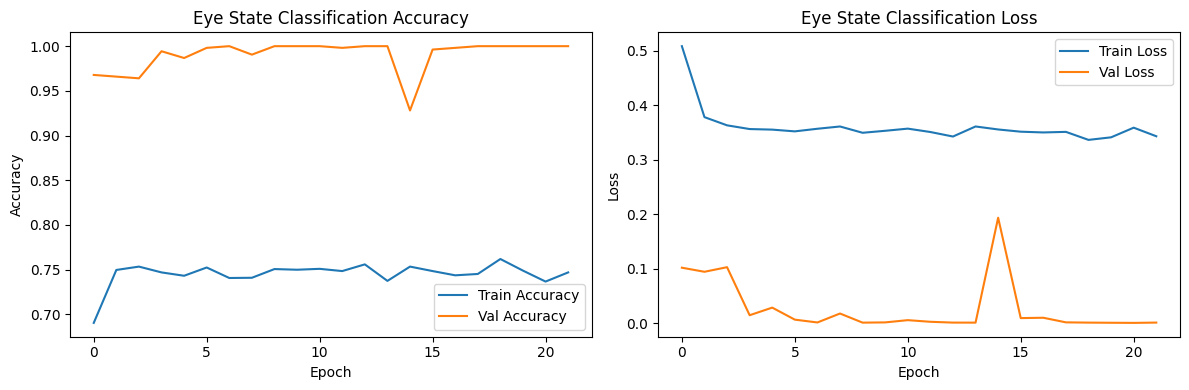

In [1]:
import os
import random
import csv
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Step 1: Generate CSV with random age assignments
def generate_age_csv(dataset_dir, output_csv):
    """Generate CSV file with random age assignments for all images"""
    image_files = []
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                relative_path = os.path.relpath(os.path.join(root, file), dataset_dir)
                image_files.append(relative_path)

    with open(output_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['filename', 'age'])
        for fname in image_files:
            age = random.randint(18, 60)  # More realistic age range
            writer.writerow([fname, age])

    print(f"CSV with assigned ages saved to {output_csv}")
    print(f"Total images processed: {len(image_files)}")

# Dataset paths
TRAIN_DIR = r"C:\Users\sarva\Emotion_detection-main\datasets\drowsiness_data\train"
VAL_DIR = r"C:\Users\sarva\Emotion_detection-main\datasets\drowsiness_data\val"
TRAIN_CSV = "train_age_labels.csv"
VAL_CSV = "val_age_labels.csv"

# Generate CSV files
generate_age_csv(TRAIN_DIR, TRAIN_CSV)
generate_age_csv(VAL_DIR, VAL_CSV)

# Step 2: Improved Data Generator with validation checks
class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, root_dir, age_csv, batch_size, img_size, shuffle=True, augment=False):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment  # Add augmentation option

        import pandas as pd
        self.df = pd.read_csv(age_csv)
        self.age_map = dict(zip(self.df['filename'], self.df['age']))
        
        # Update class names to match your folder structure
        self.classes = ['open_eyes', 'closed_eyes']
        self.class_indices = {'open_eyes': 0, 'closed_eyes': 1}

        # Validate and filter existing files
        self.filenames = []
        for fname in self.df['filename'].tolist():
            filepath = os.path.join(self.root_dir, fname)
            if os.path.exists(filepath):
                self.filenames.append(fname)

        print(f"Found {len(self.filenames)} valid images in {root_dir}")
        
        # Check class distribution
        class_counts = {'open_eyes': 0, 'closed_eyes': 0}
        for fname in self.filenames:
            class_name = fname.split(os.sep)[0]
            if class_name in class_counts:
                class_counts[class_name] += 1
        print(f"Class distribution: {class_counts}")

        if len(self.filenames) == 0:
            raise ValueError(f"No valid images found in {root_dir}")

        self.indexes = np.arange(len(self.filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return max(1, len(self.filenames) // self.batch_size)

    def __getitem__(self, index):
        batch_idx = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images, eye_states, ages = [], [], []

        for i in batch_idx:
            if i >= len(self.filenames):
                continue

            filename = self.filenames[i]
            filepath = os.path.join(self.root_dir, filename)

            # Load and preprocess image
            img = cv2.imread(filepath)
            if img is None:
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.img_size)
            
            # Apply augmentation for training data
            if self.augment and self.shuffle:
                img = self.apply_augmentation(img)
            
            img = img / 255.0  # Normalize
            images.append(img)

            # Extract class from folder name
            class_name = filename.split(os.sep)[0]
            if class_name not in self.class_indices:
                continue

            # Create one-hot eye state label
            eye_label = np.zeros(len(self.classes))
            eye_label[self.class_indices[class_name]] = 1
            eye_states.append(eye_label)

            # Normalize age to smaller range for better training
            normalized_age = (self.age_map[filename] - 18) / (60 - 18)  # Normalize to 0-1
            ages.append(normalized_age)

        if len(images) == 0:
            # Return dummy batch if no valid images
            return np.zeros((1, *self.img_size, 3)), {
                'eye_state': np.zeros((1, len(self.classes))),
                'age_pred': np.zeros((1, 1))
            }

        return np.array(images), {
            'eye_state': np.array(eye_states),
            'age_pred': np.array(ages).reshape(-1, 1)
        }

    def apply_augmentation(self, img):
        """Apply simple augmentation techniques"""
        # Random horizontal flip
        if np.random.random() > 0.5:
            img = np.fliplr(img)
        
        # Random brightness adjustment
        if np.random.random() > 0.5:
            brightness_factor = np.random.uniform(0.8, 1.2)
            img = img * brightness_factor
            img = np.clip(img, 0, 1)
        
        # Random rotation (small angle)
        if np.random.random() > 0.7:
            angle = np.random.uniform(-10, 10)
            h, w = img.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, M, (w, h))
        
        return img

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Step 3: Model definition with better architecture
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 2
BATCH_SIZE = 8  # Reduced for better training
EPOCHS = 50  # More epochs

input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Unfreeze some layers for better learning
base_model.trainable = True
# Freeze early layers, fine-tune later layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Improved architecture
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)  # Larger dense layer
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# Two output heads
eye_state_output = Dense(NUM_CLASSES, activation='softmax', name='eye_state')(x)
age_output = Dense(1, activation='sigmoid', name='age_pred')(x)  

model = Model(inputs=base_model.input, outputs=[eye_state_output, age_output])

# Better compilation with weighted losses
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss={
        'eye_state': 'categorical_crossentropy',
        'age_pred': 'mse'
    },
    loss_weights={
        'eye_state': 1.0,  # Primary task
        'age_pred': 0.1   # Secondary task (lower weight)
    },
    metrics={
        'eye_state': ['accuracy'],
        'age_pred': ['mae']
    }
)

print(model.summary())

# Step 4: Create improved generators
train_generator = MultiOutputDataGenerator(
    root_dir=TRAIN_DIR,
    age_csv=TRAIN_CSV,
    batch_size=BATCH_SIZE,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True,
    augment=True  # Enable augmentation for training
)

val_generator = MultiOutputDataGenerator(
    root_dir=VAL_DIR,
    age_csv=VAL_CSV,
    batch_size=BATCH_SIZE,
    img_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    augment=False  # No augmentation for validation
)

# Step 5: Improved callbacks
callbacks = [
    EarlyStopping(
        monitor='val_eye_state_accuracy',
        patience=15,  # More patience
        restore_best_weights=True,
        mode='max',
        verbose=1,
        min_delta=0.001  # Minimum improvement threshold
    ),
    ReduceLROnPlateau(
        monitor='val_eye_state_accuracy',
        factor=0.3,  # Less aggressive reduction
        patience=8,
        mode='max',
        verbose=1,
        min_lr=1e-7
    ),
    ModelCheckpoint(
        'drowsiness_model.h5',
        monitor='val_eye_state_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )
]

# Step 6: Train with better strategy
print("Starting model training with improved configuration...")

# Initial training with frozen base
print("Phase 1: Training with mostly frozen base model...")
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("Training completed successfully!")
print("Model saved as 'drowsiness_model.h5'")

# Optional: Plot training history
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['eye_state_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_eye_state_accuracy'], label='Val Accuracy')
    plt.title('Eye State Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['eye_state_loss'], label='Train Loss')
    plt.plot(history.history['val_eye_state_loss'], label='Val Loss')
    plt.title('Eye State Classification Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
except ImportError:
    print("Matplotlib not available for plotting")
